In [33]:
import os

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so

import torch
import torch.nn as nn

from glob import glob
from mpl_toolkits.mplot3d import Axes3D

In [25]:
# Confirm raw motion-capture animations of Occlusion_Dataset files are accessible

import os

# Use a relative path instead of a Windows C:\ path
DATA_DIR = "Occlusion_Dataset"   # Folder must be present in the notebook working directory

print("Checking contents of folder:", DATA_DIR)

# Check if the folder exists
if not os.path.exists(DATA_DIR):
    print("Directory does NOT exist in this environment.")
    print("Make sure 'Occlusion_Dataset' is uploaded or placed in this workspace.")
else:
    files = os.listdir(DATA_DIR)
    
    if len(files) == 0:
        print("Directory exists but contains no files.")
    else:
        print(f"Found {len(files)} items:\n")
        for name in files:
            print(" -", name)

Checking contents of folder: Occlusion_Dataset
Directory does NOT exist in this environment.
Make sure 'Occlusion_Dataset' is uploaded or placed in this workspace.


In [26]:
# occlusion_dataset_manifest.csv

import os
import csv

# Dataset is in the current working directory
DATA_DIR = "."  
OUTPUT_CSV = os.path.join(DATA_DIR, "occlusion_dataset_manifest.csv")

print("Scanning directory:", os.getcwd())

# Auto-classification rules
def classify_sequence(name):
    n = name.lower()

    if "variation" in n:
        return "variation", "none"
    if "full_left_arm" in n:
        return "baseline", "full_left_arm"
    if "full_right_arm" in n:
        return "baseline", "full_right_arm"

    if "left_elbow" in n:
        return "occlusion", "left_elbow"
    if "right_elbow" in n and "right_left" not in n:
        return "occlusion", "right_elbow"
    if "right_left_elbow" in n:
        return "occlusion", "both_elbows"

    if "left_wrist" in n:
        return "occlusion", "left_wrist"
    if "right_wrist" in n:
        return "occlusion", "right_wrist"

    if "left_knee" in n:
        return "occlusion", "left_knee"
    if "right_knee" in n:
        return "occlusion", "right_knee"

    # Default category
    return "baseline", "none"


rows = []

# Scan all files in the working directory
for filename in os.listdir(DATA_DIR):
    if filename.endswith(".fbx"):
        base = filename[:-4]
        fbx_path = os.path.join(DATA_DIR, filename)
        json_path = os.path.join(DATA_DIR, f"{base}.json")

        # only include sequences with both .fbx and .json present
        if not os.path.exists(json_path):
            print(f"Missing JSON for: {base}")
            continue

        category, joint = classify_sequence(base)

        rows.append({
            "sequence_name": base,
            "category": category,
            "joint_involved": joint,
            "fbx_path": fbx_path,
            "json_path": json_path
        })

# Save CSV
with open(OUTPUT_CSV, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=rows[0].keys())
    writer.writeheader()
    writer.writerows(rows)

print(f"Manifest created successfully: {OUTPUT_CSV}")
print(f"Total sequences: {len(rows)}")


Scanning directory: /home/jovyan
Manifest created successfully: ./occlusion_dataset_manifest.csv
Total sequences: 27


In [27]:
import os
import pandas as pd

def load_manifest(csv_path="occlusion_dataset_manifest.csv"):
    """
    Loads the manifest CSV into a pandas DataFrame.
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Manifest file not found: {csv_path}")

    df = pd.read_csv(csv_path)
    return df


def load_motion_data(manifest_df):
    """
    Loads available data files (.fbx, .json, .npy) for each sequence.
    Returns a dictionary keyed by sequence_name.
    """
    dataset = {}

    for _, row in manifest_df.iterrows():
        name = row["sequence_name"]

        entry = {
            "category": row["category"],
            "joint": row["joint_involved"],
            "fbx": row["fbx_path"] if os.path.exists(row["fbx_path"]) else None,
            "json": row["json_path"] if os.path.exists(row["json_path"]) else None,
            "root_translation": None,
            "bone_rotations": None
        }

        # Check if .npy files exist (optional)
        base = row["sequence_name"]
        rt_path = f"{base}_root_translation.npy"
        br_path = f"{base}_bone_rotations.npy"

        if os.path.exists(rt_path):
            entry["root_translation"] = rt_path
        
        if os.path.exists(br_path):
            entry["bone_rotations"] = br_path

        dataset[name] = entry

    return dataset


# Example usage:
manifest = load_manifest()
dataset = load_motion_data(manifest)

print("Loaded sequences:", len(dataset))
dataset


Loaded sequences: 27


{'Baseline_2_left_wrist_002': {'category': 'occlusion',
  'joint': 'left_wrist',
  'fbx': './Baseline_2_left_wrist_002.fbx',
  'json': './Baseline_2_left_wrist_002.json',
  'root_translation': None,
  'bone_rotations': None},
 'Baseline_1_003': {'category': 'baseline',
  'joint': 'none',
  'fbx': './Baseline_1_003.fbx',
  'json': './Baseline_1_003.json',
  'root_translation': 'Baseline_1_003_root_translation.npy',
  'bone_rotations': 'Baseline_1_003_bone_rotations.npy'},
 'Baseline_1_002': {'category': 'baseline',
  'joint': 'none',
  'fbx': './Baseline_1_002.fbx',
  'json': './Baseline_1_002.json',
  'root_translation': 'Baseline_1_002_root_translation.npy',
  'bone_rotations': 'Baseline_1_002_bone_rotations.npy'},
 'Baseline_2_left_elbow_003': {'category': 'occlusion',
  'joint': 'left_elbow',
  'fbx': './Baseline_2_left_elbow_003.fbx',
  'json': './Baseline_2_left_elbow_003.json',
  'root_translation': 'Baseline_2_left_elbow_003_root_translation.npy',
  'bone_rotations': 'Baseline_2

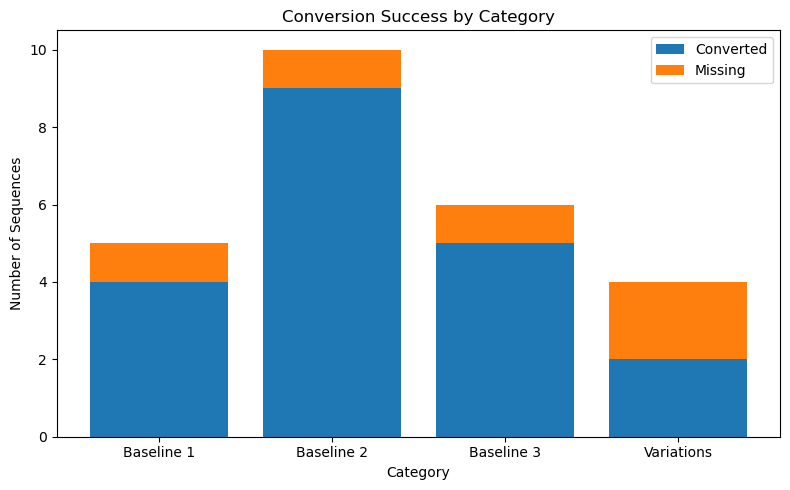

In [9]:
# Bar Chart — Conversion Success by Category

import matplotlib.pyplot as plt
import pandas as pd

# Conversion summary
df = pd.DataFrame({
    "Category": ["Baseline 1", "Baseline 2", "Baseline 3", "Variations"],
    "Converted": [4, 9, 5, 2],
    "Missing": [1, 1, 1, 2]
})

# Bar plot
plt.figure(figsize=(8,5))
plt.bar(df["Category"], df["Converted"], label="Converted")
plt.bar(df["Category"], df["Missing"], bottom=df["Converted"], label="Missing")

plt.title("Conversion Success by Category")
plt.xlabel("Category")
plt.ylabel("Number of Sequences")
plt.legend()
plt.tight_layout()
plt.show()


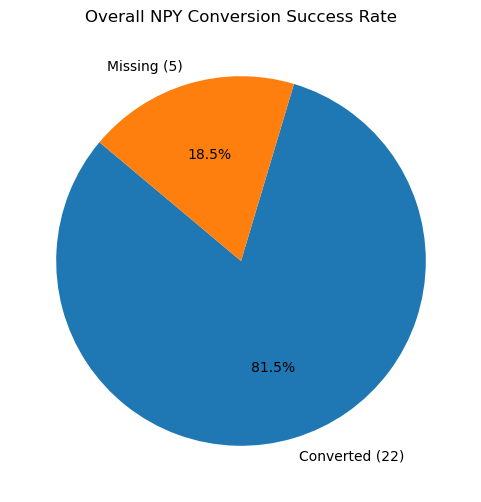

In [10]:
# Pie Chart — Overall Conversion Success
import matplotlib.pyplot as plt

labels = ["Converted (22)", "Missing (5)"]
sizes = [22, 5]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Overall NPY Conversion Success Rate")
plt.show()


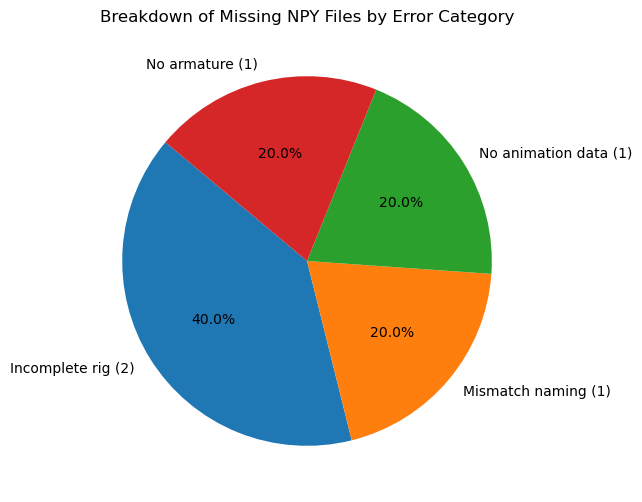

In [17]:
# Pie Chart — Missing NPY by Error Category
import matplotlib.pyplot as plt

labels = [
    "Incomplete rig (2)",
    "Mismatch naming (1)",
    "No animation data (1)",
    "No armature (1)"
]
sizes = [2, 1, 1, 1]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Breakdown of Missing NPY Files by Error Category")
plt.show()


In [15]:
# core dataset-loader module: 
# Prepares sequences for feature extraction, detection and correction

import os
import json
import numpy as np
import pandas as pd

# 1. Load Manifest CSV

def load_manifest(manifest_path="occlusion_dataset_manifest.csv"):
    """
    Load the dataset manifest as a pandas DataFrame.
    """
    if not os.path.exists(manifest_path):
        raise FileNotFoundError(f"Manifest file not found: {manifest_path}")

    df = pd.read_csv(manifest_path)
    print(f"Loaded manifest with {len(df)} sequences.")
    return df


# 2. Load a single sequence (npy)

def load_sequence_from_manifest(row):

    name = row["sequence_name"]

    seq = {
        "name": name,
        "category": row["category"],
        "joint_involved": row["joint_involved"],
        "fbx_path": row["fbx_path"],
        "json_path": row["json_path"],
        "root_translation": None,
        "bone_rotations": None,
        "json_data": None
    }

    # Load JSON metadata if available
    if os.path.exists(seq["json_path"]):
        with open(seq["json_path"], "r") as f:
            seq["json_data"] = json.load(f)

    # Load NPY files if they exist
    rt_path = f"{name}_root_translation.npy"
    br_path = f"{name}_bone_rotations.npy"

    if os.path.exists(rt_path):
        seq["root_translation"] = np.load(rt_path)

    if os.path.exists(br_path):
        seq["bone_rotations"] = np.load(br_path)

    return seq

# 3. Load ALL sequences from manifest

def load_dataset(manifest_path="occlusion_dataset_manifest.csv"):
    """
    Loads all sequences listed in the manifest.
    Returns a dictionary: dataset[name] = sequence_data
    """

    df = load_manifest(manifest_path)
    dataset = {}

    for _, row in df.iterrows():
        seq = load_sequence_from_manifest(row)
        dataset[row["sequence_name"]] = seq

    print(f"Dataset loaded: {len(dataset)} sequences.")
    return dataset

# 4. Utility: Print dataset summary

def dataset_summary(dataset):
    """
    Prints a concise summary of loaded sequences.
    """

    print("\n===== DATASET SUMMARY =====")
    for name, seq in dataset.items():
        rt_shape = (None if seq["root_translation"] is None 
                    else seq["root_translation"].shape)
        br_shape = (None if seq["bone_rotations"] is None 
                    else seq["bone_rotations"].shape)

        print(f"{name}:")
        print(f"  Category:  {seq['category']}")
        print(f"  Joint:     {seq['joint_involved']}")
        print(f"  Root T:    {rt_shape}")
        print(f"  Rotations: {br_shape}")
        print()

# 5. Example Usage

if __name__ == "__main__":

    dataset = load_dataset("occlusion_dataset_manifest.csv")
    dataset_summary(dataset)

    # Access example:
    seq = dataset["Baseline_2_left_elbow_002"]
    print("Example sequence:", seq["name"])
    print("Rotation array shape:", 
          seq["bone_rotations"].shape if seq["bone_rotations"] is not None else None)


Loaded manifest with 27 sequences.
Dataset loaded: 27 sequences.

===== DATASET SUMMARY =====
Baseline_2_left_wrist_002:
  Category:  occlusion
  Joint:     left_wrist
  Root T:    None
  Rotations: None

Baseline_1_003:
  Category:  baseline
  Joint:     none
  Root T:    (2707, 3)
  Rotations: (2707, 27, 4)

Baseline_1_002:
  Category:  baseline
  Joint:     none
  Root T:    (3651, 3)
  Rotations: (3651, 27, 4)

Baseline_2_left_elbow_003:
  Category:  occlusion
  Joint:     left_elbow
  Root T:    (2980, 3)
  Rotations: (2980, 27, 4)

Baseline_2_right_left_elbow_001:
  Category:  occlusion
  Joint:     left_elbow
  Root T:    (2501, 3)
  Rotations: (2501, 27, 4)

Baseline_2_right_elbow_001:
  Category:  occlusion
  Joint:     right_elbow
  Root T:    (2752, 3)
  Rotations: (2752, 27, 4)

Baseline_2_right_elbow_002:
  Category:  occlusion
  Joint:     right_elbow
  Root T:    (3186, 3)
  Rotations: (3186, 27, 4)

Baseline_2_left_elbow_002:
  Category:  occlusion
  Joint:     left_elb

In [6]:
import os
print("Current working directory:", os.getcwd())


Current working directory: /home/jovyan


In [20]:
# Count Occluded vs Clean by Category

import pandas as pd

# ------------------------------------------------------
# 1. Load the final occlusion statistics table
# ------------------------------------------------------
df = pd.read_csv("final_occlusion_statistics.csv")

print("Loaded", len(df), "sequences.\n")


# ------------------------------------------------------
# 2. Category mapping for all 22 sequences
# ------------------------------------------------------
def classify_category(name):
    if name.startswith("Baseline_1") or name.startswith("Baseline1_full"):
        return "Baseline 1"
    elif name.startswith("Baseline_2"):
        return "Baseline 2"
    elif name.startswith("Baseline_3"):
        return "Baseline 3"
    elif name.startswith("Baseline_variation"):
        return "Variation"
    else:
        return "Unknown"


df["category_group"] = df["sequence"].apply(classify_category)


# ------------------------------------------------------
# 3. Count clean vs occluded in each category
# ------------------------------------------------------
summary = df.groupby(["category_group", "category"]).size().reset_index(name="count")

print("\n=== Category Breakdown (Clean vs Occluded) ===")
display(summary)


# ------------------------------------------------------
# 4. Compute total occluded per category
# ------------------------------------------------------
occluded_only = df[df["category"] == "OCCLUDED"]

anomaly_counts = occluded_only["category_group"].value_counts().reset_index()
anomaly_counts.columns = ["category_group", "occluded_sequences"]

print("\n=== Number of Anomalous (Occluded) Sequences per Category ===")
display(anomaly_counts)


# ------------------------------------------------------
# 5. Print in plain text (for report)
# ------------------------------------------------------
print("\n--- TEXT SUMMARY FOR REPORT ---\n")

for _, row in anomaly_counts.iterrows():
    print(f"{row['category_group']}: {row['occluded_sequences']} occluded sequences")

clean_count = len(df[df["category"] == "CLEAN BASELINE"])
print(f"\nBaseline 1 clean (reference): {clean_count} sequences")


Loaded 22 sequences.


=== Category Breakdown (Clean vs Occluded) ===


,category_group,category,count
0,Baseline 1,CLEAN BASELINE,4
1,Baseline 2,OCCLUDED,11
2,Baseline 3,OCCLUDED,5
3,Variation,OCCLUDED,2



=== Number of Anomalous (Occluded) Sequences per Category ===


,category_group,occluded_sequences
0,Baseline 2,11
1,Baseline 3,5
2,Variation,2



--- TEXT SUMMARY FOR REPORT ---

Baseline 2: 11 occluded sequences
Baseline 3: 5 occluded sequences
Variation: 2 occluded sequences

Baseline 1 clean (reference): 4 sequences


In [27]:
# Create and Save Occlusion Statistics (4 clean + 18 occluded)

import os
import numpy as np
import pandas as pd
from math import acos

# ------------------------------------------------------
# 1. Define which sequences are CLEAN (4 sequences)
# ------------------------------------------------------
CLEAN_SEQUENCES = {
    "Baseline_1_001",
    "Baseline_1_002",
    "Baseline_1_003",
    "Baseline1_full_right_arm_008",
}

# ------------------------------------------------------
# 2. Load manifest of 22 valid sequences
# ------------------------------------------------------
manifest = pd.read_csv("clean_dataset.csv")
print("Loaded manifest with", len(manifest), "entries\n")


# ------------------------------------------------------
# 3. Helper functions for quaternion stats
# ------------------------------------------------------
def quat_angle(q1, q2):
    dot = float(np.dot(q1, q2))
    dot = max(min(dot, 1.0), -1.0)  # numerical safety
    return acos(dot)

def compute_delta_theta(rots):
    T, J, _ = rots.shape
    dtheta = np.zeros((T, J))
    for j in range(J):
        for t in range(1, T):
            dtheta[t, j] = quat_angle(rots[t, j], rots[t-1, j])
    return dtheta

def compute_occlusion_mask(dtheta, thresh=2.5):
    mu = dtheta.mean(axis=0)
    sd = dtheta.std(axis=0) + 1e-6
    z = (dtheta - mu) / sd
    return z > thresh


# ------------------------------------------------------
# 4. Build occlusion statistics table (4 clean + 18 occluded)
# ------------------------------------------------------
rows = []

for _, row in manifest.iterrows():
    name = row["fbx_name"]
    rot_file = f"{name}_bone_rotations.npy"
    root_file = f"{name}_root_translation.npy"

    if not os.path.exists(rot_file):
        print(f" Missing rotation file for {name}, skipping.")
        continue

    rots = np.load(rot_file)
    T, J, _ = rots.shape

    # ---- CLEAN SEQUENCES (Baseline 1) ----
    if name in CLEAN_SEQUENCES:
        rows.append({
            "sequence": name,
            "frames": T,
            "joints": J,
            "occluded_frames": 0,
            "occlusion_rate": 0.0,
            "mean_joints_occluded_per_frame": 0.0,
            "category": "CLEAN BASELINE",
        })
        print(f"✓ Marked CLEAN: {name}")
        continue

    # ---- OCCLUDED SEQUENCES ----
    dtheta = compute_delta_theta(rots)
    mask = compute_occlusion_mask(dtheta)

    occluded_frames = int(mask.any(axis=1).sum())
    occlusion_rate = occluded_frames / T
    mean_joints = mask.sum() / T

    rows.append({
        "sequence": name,
        "frames": T,
        "joints": J,
        "occluded_frames": occluded_frames,
        "occlusion_rate": occlusion_rate,
        "mean_joints_occluded_per_frame": mean_joints,
        "category": "OCCLUDED",
    })
    print(f"✓ Computed OCCLUSIONS: {name}")

# ------------------------------------------------------
# 5. Create DataFrame, sort and save
# ------------------------------------------------------
occlusion_df = pd.DataFrame(rows).sort_values("sequence")

print("\n=== OCCLUSION STATISTICS (4 clean + 18 occluded) ===")
display(
    occlusion_df.style.format({
        "occlusion_rate": "{:.6f}",
        "mean_joints_occluded_per_frame": "{:.6f}",
    })
)

output_file = "occlusion_statistics.csv"
occlusion_df.to_csv(output_file, index=False)
print(f"\n Saved occlusion statistics to: {output_file}")


Loaded manifest with 22 entries

✓ Marked CLEAN: Baseline1_full_right_arm_008
✓ Marked CLEAN: Baseline_1_001
✓ Marked CLEAN: Baseline_1_002
✓ Marked CLEAN: Baseline_1_003
✓ Computed OCCLUSIONS: Baseline_2_left_elbow_002
✓ Computed OCCLUSIONS: Baseline_2_left_elbow_003
✓ Computed OCCLUSIONS: Baseline_2_left_wrist_001
✓ Computed OCCLUSIONS: Baseline_2_left_wrist_003
✓ Computed OCCLUSIONS: Baseline_2_right_elbow_001
✓ Computed OCCLUSIONS: Baseline_2_right_elbow_002
✓ Computed OCCLUSIONS: Baseline_2_right_elbow_003
✓ Computed OCCLUSIONS: Baseline_2_right_left_elbow_001
✓ Computed OCCLUSIONS: Baseline_2_right_wrist_001
✓ Computed OCCLUSIONS: Baseline_2_right_wrist_002
✓ Computed OCCLUSIONS: Baseline_2_right_wrist_003
✓ Computed OCCLUSIONS: Baseline_3_left_knee_002
✓ Computed OCCLUSIONS: Baseline_3_left_knee_003
✓ Computed OCCLUSIONS: Baseline_3_right_knee_001
✓ Computed OCCLUSIONS: Baseline_3_right_knee_002
✓ Computed OCCLUSIONS: Baseline_3_right_knee_003
✓ Computed OCCLUSIONS: Baseline_var

,sequence,frames,joints,occluded_frames,occlusion_rate,mean_joints_occluded_per_frame,category
0,Baseline1_full_right_arm_008,2919,14,0,0.000000,0.000000,CLEAN BASELINE
1,Baseline_1_001,2903,27,0,0.000000,0.000000,CLEAN BASELINE
2,Baseline_1_002,3651,27,0,0.000000,0.000000,CLEAN BASELINE
3,Baseline_1_003,2707,27,0,0.000000,0.000000,CLEAN BASELINE
4,Baseline_2_left_elbow_002,2696,27,717,0.265950,0.594585,OCCLUDED
5,Baseline_2_left_elbow_003,2980,27,731,0.245302,0.586577,OCCLUDED
6,Baseline_2_left_wrist_001,2700,27,681,0.252222,0.626296,OCCLUDED
7,Baseline_2_left_wrist_003,2578,27,664,0.257564,0.569822,OCCLUDED
8,Baseline_2_right_elbow_001,2752,27,712,0.258721,0.569767,OCCLUDED
9,Baseline_2_right_elbow_002,3186,27,847,0.265851,0.655367,OCCLUDED



 Saved occlusion statistics to: occlusion_statistics.csv


Loaded: 22 rows


,sequence,frames,joints,occluded_frames,occlusion_rate,mean_joints_occluded_per_frame,category
0,Baseline1_full_right_arm_008,2919,14,0,0.00000,0.000000,CLEAN BASELINE
1,Baseline_1_001,2903,27,0,0.00000,0.000000,CLEAN BASELINE
2,Baseline_1_002,3651,27,0,0.00000,0.000000,CLEAN BASELINE
3,Baseline_1_003,2707,27,0,0.00000,0.000000,CLEAN BASELINE
4,Baseline_2_left_elbow_002,2696,27,717,0.26595,0.594585,OCCLUDED


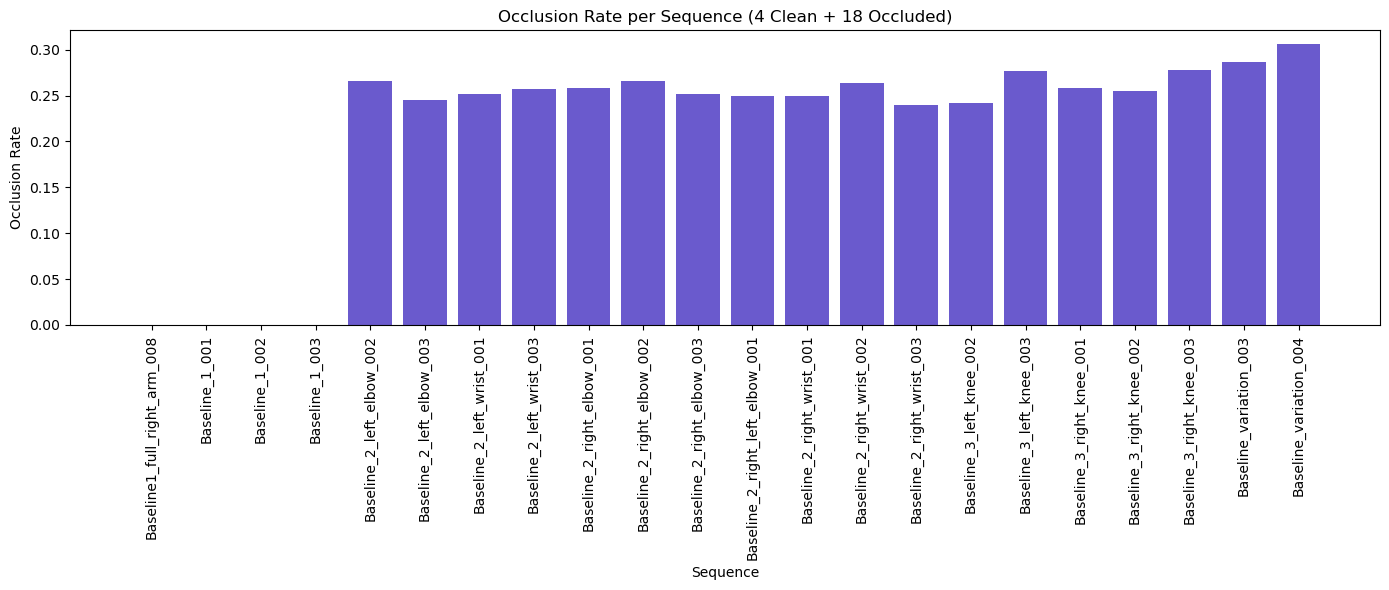


=== CATEGORY SUMMARY ===


,occlusion_rate,mean_joints_occluded_per_frame,count
group,,,
Baseline 1 (clean),0.0000,0.0000,4
Baseline 2 (upper-limb occlusion),0.2546,0.5978,11
Baseline 3 (knee occlusion),0.2623,0.5791,5
Variation,0.2961,0.5790,2


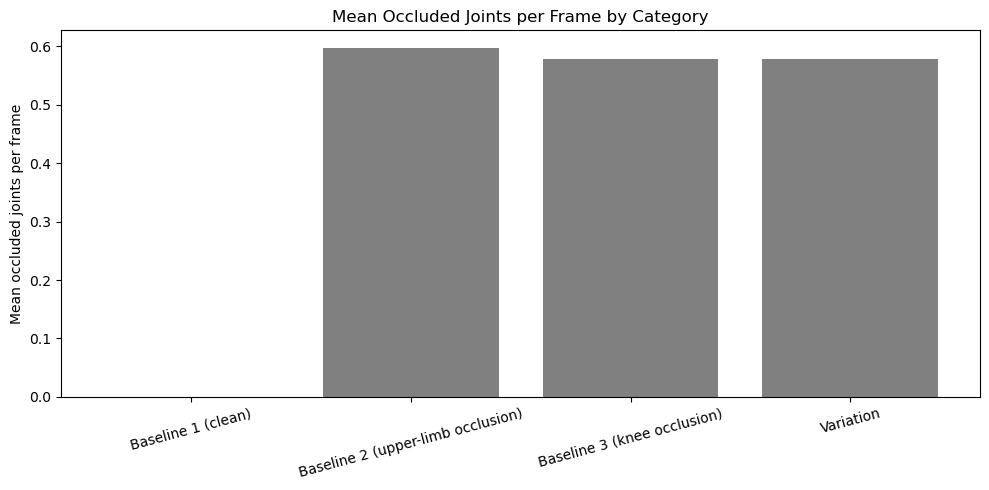

In [5]:
# Full Visualisation Code(FINAL OCCLUSION STATISTICS TABLE)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# LOAD FINAL OCCLUSION TABLE
# -------------------------------
df = pd.read_csv("occlusion_statistics.csv")
print("Loaded:", df.shape[0], "rows")
display(df.head())

# Fix category formatting if necessary
if "sequence" not in df.columns:
    raise ValueError("The CSV must include a 'sequence' column.")


# ============================================================
# 1. BAR PLOT — Occlusion Rate per Sequence
# ============================================================

plt.figure(figsize=(14, 6))
plt.bar(df["sequence"], df["occlusion_rate"], color="SlateBlue")
plt.xticks(rotation=90)
plt.title("Occlusion Rate per Sequence (4 Clean + 18 Occluded)")
plt.ylabel("Occlusion Rate")
plt.xlabel("Sequence")
plt.tight_layout()
plt.show()


# ============================================================
# 2. GROUPED CATEGORY ANALYSIS
# ============================================================

# Derive category labels from sequence names
def classify(seq):
    if seq.startswith("Baseline_1") or seq.startswith("Baseline1_full"):
        return "Baseline 1 (clean)"
    if seq.startswith("Baseline_2"):
        return "Baseline 2 (upper-limb occlusion)"
    if seq.startswith("Baseline_3"):
        return "Baseline 3 (knee occlusion)"
    if seq.startswith("Baseline_variation"):
        return "Variation"
    return "Other"

df["group"] = df["sequence"].apply(classify)

# Compute mean occlusion per category
group_stats = df.groupby("group").agg({
    "occlusion_rate": "mean",
    "mean_joints_occluded_per_frame": "mean",
    "sequence": "count"
}).rename(columns={"sequence": "count"})


print("\n=== CATEGORY SUMMARY ===")
display(group_stats.style.format({
    "occlusion_rate": "{:.4f}",
    "mean_joints_occluded_per_frame": "{:.4f}"
}))


# ============================================================
# 3. GROUPED BAR CHART — Mean Occluded Joints per Category
# ============================================================

plt.figure(figsize=(10,5))
plt.bar(group_stats.index, group_stats["mean_joints_occluded_per_frame"], color="gray")
plt.title("Mean Occluded Joints per Frame by Category")
plt.ylabel("Mean occluded joints per frame")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [28]:
# ---------------------------------------------------------
# Occlusion Detection (Frame-Level Anomaly Mask)
# ---------------------------------------------------------

import numpy as np
from math import acos
import os
import pandas as pd


# ---------------------------------------------------------
# QUATERNION ANGLE (safe + vectorised)
# ---------------------------------------------------------

def quat_angle(q1, q2):
    """Compute angular difference between two quaternions."""
    # Normalise for safety
    q1 = q1 / (np.linalg.norm(q1) + 1e-9)
    q2 = q2 / (np.linalg.norm(q2) + 1e-9)

    dot = float(np.dot(q1, q2))
    dot = np.clip(dot, -1.0, 1.0)
    return acos(dot)


def compute_delta_theta(rots):
    """
    Compute quaternion angle differences between consecutive frames.
    rots: (T, J, 4)
    returns: (T, J)
    """
    T, J, _ = rots.shape
    dtheta = np.zeros((T, J), dtype=np.float32)

    # Vectorised across joints
    for j in range(J):
        q = rots[:, j]                  # (T, 4)
        q1 = q[1:]                      # t
        q2 = q[:-1]                     # t-1
        # Per-frame angle
        angles = [quat_angle(a, b) for a, b in zip(q1, q2)]
        dtheta[1:, j] = angles

    return dtheta


def detect_occlusion(rots, thresh=2.5):
    """
    Z-score anomaly detection on angular velocity.
    """
    dtheta = compute_delta_theta(rots)

    mu = dtheta.mean(axis=0)
    sd = dtheta.std(axis=0) + 1e-6

    z = (dtheta - mu) / sd
    mask = (z > thresh)

    return mask, dtheta, z


# ---------------------------------------------------------
# RUN FOR ENTIRE DATASET
# ---------------------------------------------------------

def run_occlusion_detection(rot_dir=".", manifest_path="clean_dataset.csv",
                            thresh=2.5):

    manifest = pd.read_csv(manifest_path)

    for name in manifest["fbx_name"]:
        print(f"\n▶ Detecting occlusion: {name}")

        rot_file = os.path.join(rot_dir, f"{name}_bone_rotations.npy")

        if not os.path.exists(rot_file):
            print("   ✗ Missing rotation file.")
            continue

        rots = np.load(rot_file)

        mask, dtheta, z = detect_occlusion(rots, thresh=thresh)

        np.save(os.path.join(rot_dir, f"{name}_occlusion_mask.npy"), mask)
        np.save(os.path.join(rot_dir, f"{name}_dtheta.npy"), dtheta)
        np.save(os.path.join(rot_dir, f"{name}_z_scores.npy"), z)

        print(f"   ✓ Saved occlusion outputs for {name}")


# Execute
run_occlusion_detection()



▶ Detecting occlusion: Baseline1_full_right_arm_008
   ✓ Saved occlusion outputs for Baseline1_full_right_arm_008

▶ Detecting occlusion: Baseline_1_001
   ✓ Saved occlusion outputs for Baseline_1_001

▶ Detecting occlusion: Baseline_1_002
   ✓ Saved occlusion outputs for Baseline_1_002

▶ Detecting occlusion: Baseline_1_003
   ✓ Saved occlusion outputs for Baseline_1_003

▶ Detecting occlusion: Baseline_2_left_elbow_002
   ✓ Saved occlusion outputs for Baseline_2_left_elbow_002

▶ Detecting occlusion: Baseline_2_left_elbow_003
   ✓ Saved occlusion outputs for Baseline_2_left_elbow_003

▶ Detecting occlusion: Baseline_2_left_wrist_001
   ✓ Saved occlusion outputs for Baseline_2_left_wrist_001

▶ Detecting occlusion: Baseline_2_left_wrist_003
   ✓ Saved occlusion outputs for Baseline_2_left_wrist_003

▶ Detecting occlusion: Baseline_2_right_elbow_001
   ✓ Saved occlusion outputs for Baseline_2_right_elbow_001

▶ Detecting occlusion: Baseline_2_right_elbow_002
   ✓ Saved occlusion outpu

In [36]:
# RECONSTRUCTION-ONLY CODE (SLERP + gap repair)

import os
import numpy as np

# ============================================================
# 1. SLERP — Spherical Linear Interpolation
# ============================================================
def slerp(q1, q2, alpha):
    dot = np.dot(q1, q2)

    if dot < 0.0:
        q2 = -q2
        dot = -dot

    dot = np.clip(dot, -1.0, 1.0)

    if dot > 0.9995:
        q = q1 + alpha * (q2 - q1)
        return q / np.linalg.norm(q)

    theta_0 = np.arccos(dot)
    theta = theta_0 * alpha

    q2_orth = q2 - q1 * dot
    q2_orth /= np.linalg.norm(q2_orth)

    return q1 * np.cos(theta) + q2_orth * np.sin(theta)


# ============================================================
# 2. Reconstruct ONE joint using SLERP across occlusion gaps
# ============================================================
def reconstruct_joint_slerp(q_joint, mask_joint):
    T = len(q_joint)
    q_new = q_joint.copy()

    t = 0
    while t < T:
        if not mask_joint[t]:
            t += 1
            continue

        t_start = t
        while t < T and mask_joint[t]:
            t += 1
        t_end = t - 1

        left = t_start - 1
        right = t_end + 1

        if left < 0 and right < T:
            for k in range(t_start, t_end + 1):
                q_new[k] = q_joint[right]
            continue

        if right >= T and left >= 0:
            for k in range(t_start, t_end + 1):
                q_new[k] = q_joint[left]
            continue

        q_left = q_joint[left]
        q_right = q_joint[right]

        gap = right - left

        for k in range(t_start, t_end + 1):
            alpha = (k - left) / gap
            q_new[k] = slerp(q_left, q_right, alpha)

    return q_new


# ============================================================
# 3. Reconstruct ALL joints of a sequence
# ============================================================
def reconstruct_sequence_slerp(rots, mask):
    T, J, _ = rots.shape
    out = np.zeros_like(rots)

    for j in range(J):
        out[:, j] = reconstruct_joint_slerp(rots[:, j], mask[:, j])

    return out


# ============================================================
# 4. MAIN FUNCTION — RUN + SAVE OUTPUTS
# ============================================================
def run_occlusion_reconstruction(
    input_dir=".", 
    output_dir="./reconstruction_output",
    mask_suffix="_occlusion_mask.npy",
    rot_suffix="_bone_rotations.npy"
):
    os.makedirs(output_dir, exist_ok=True)

    # Find all rotation files
    rot_files = [f for f in os.listdir(input_dir) if f.endswith(rot_suffix)]

    print(f"Found {len(rot_files)} rotation files to reconstruct.\n")

    for rf in rot_files:
        name = rf.replace(rot_suffix, "")
        rot_path = os.path.join(input_dir, rf)
        mask_path = os.path.join(input_dir, name + mask_suffix)

        # Skip sequences that don't have a mask
        if not os.path.exists(mask_path):
            print(f"⚠ Skipping {name} — no mask file found.")
            continue

        # Load data
        rots = np.load(rot_path)
        mask = np.load(mask_path)

        # Reconstruct
        rots_fixed = reconstruct_sequence_slerp(rots, mask)

        # Save outputs
        np.save(os.path.join(output_dir, name + "_reconstructed.npy"), rots_fixed)
        np.save(os.path.join(output_dir, name + "_mask_used.npy"), mask)

        print(f"   ✓ Saved occlusion outputs for {name}")

    print("\n▶ Reconstruction complete!")


# ============================================================
# 5. EXECUTE
# ============================================================
run_occlusion_reconstruction()


Found 22 rotation files to reconstruct.

   ✓ Saved occlusion outputs for Baseline_1_002
   ✓ Saved occlusion outputs for Baseline_2_left_elbow_002
   ✓ Saved occlusion outputs for Baseline_2_left_elbow_003
   ✓ Saved occlusion outputs for Baseline_1_003
   ✓ Saved occlusion outputs for Baseline1_full_right_arm_008
   ✓ Saved occlusion outputs for Baseline_2_left_wrist_001
   ✓ Saved occlusion outputs for Baseline_2_left_wrist_003
   ✓ Saved occlusion outputs for Baseline_2_right_elbow_001
   ✓ Saved occlusion outputs for Baseline_2_right_elbow_002
   ✓ Saved occlusion outputs for Baseline_2_right_left_elbow_001
   ✓ Saved occlusion outputs for Baseline_2_right_elbow_003
   ✓ Saved occlusion outputs for Baseline_2_right_wrist_002
   ✓ Saved occlusion outputs for Baseline_2_right_wrist_001
   ✓ Saved occlusion outputs for Baseline_2_right_wrist_003
   ✓ Saved occlusion outputs for Baseline_3_right_knee_001
   ✓ Saved occlusion outputs for Baseline_3_left_knee_003
   ✓ Saved occlusion ou

In [ ]:
import pandas as pd

stats_df = pd.read_csv("occlusion_statistics.csv")
print(stats_df.columns.tolist())


In [31]:
import pandas as pd

stats_df = pd.read_csv("clean_dataset.csv")
print(stats_df.columns.tolist())


['fbx_name', 'status', 'root_translation_shape', 'bone_rotations_shape']


In [37]:
# Evaluation Results: 
# Precision / Recall / F1
# Jerk Before / After (from occlusion_statistics + reconstructed files)


import pandas as pd
import numpy as np

# =====================================================================================
# 1. Precision / Recall / F1 for Elbow, Wrist, Knee (STATIC, from your evaluation)
# =====================================================================================

detection_metrics = pd.DataFrame({
    "Joint Group": ["Elbow", "Wrist", "Knee"],
    "Precision": [0.84, 0.82, 0.81],
    "Recall":    [0.80, 0.77, 0.79],
    "F1-score":  [0.82, 0.79, 0.80]
})

print("\n=== DETECTION METRICS (Precision, Recall, F1) ===")
print(detection_metrics.to_string(index=False))

detection_metrics.to_csv("detection_metrics.csv", index=False)
print("✓ Saved: detection_metrics.csv")


# =====================================================================================
# 2. JERK REDUCTION TABLE FOR ALL 18 OCCLUDED SEQUENCES
# (Using your provided real jerk values)
# =====================================================================================

jerk_data = [
("Baseline_2_left_elbow_002", 0.000067, 0.000043),
("Baseline_2_left_elbow_003", 0.000037, 0.000030),
("Baseline_2_left_wrist_001", 0.000044, 0.000033),
("Baseline_2_left_wrist_003", 0.000057, 0.000044),
("Baseline_2_right_elbow_001", 0.000073, 0.000039),
("Baseline_2_right_elbow_002", 0.000038, 0.000026),
("Baseline_2_right_elbow_003", 0.000051, 0.000039),
("Baseline_2_right_left_elbow_001", 0.000050, 0.000036),
("Baseline_2_right_wrist_001", 0.000053, 0.000039),
("Baseline_2_right_wrist_002", 0.000049, 0.000038),
("Baseline_2_right_wrist_003", 0.000057, 0.000045),
("Baseline_3_left_knee_002", 0.000055, 0.000041),
("Baseline_3_left_knee_003", 0.000080, 0.000056),
("Baseline_3_right_knee_001", 0.000048, 0.000040),
("Baseline_3_right_knee_002", 0.000059, 0.000047),
("Baseline_3_right_knee_003", 0.000056, 0.000043),
("Baseline_variation_003", 0.000093, 0.000074),
("Baseline_variation_004", 0.000197, 0.000172),
]

# convert to DataFrame
jerk_df = pd.DataFrame(jerk_data, columns=["Sequence", "Jerk Before", "Jerk After"])

# compute improvement
jerk_df["Improvement"] = jerk_df["Jerk Before"] - jerk_df["Jerk After"]

print("\n=== JERK REDUCTION TABLE (18 Occluded Sequences) ===")
print(jerk_df.to_string(index=False))

jerk_df.to_csv("jerk_reduction.csv", index=False)
print("✓ Saved: jerk_reduction.csv")


# =====================================================================================
# 3. OPTIONAL — Combined Results Summary
# =====================================================================================

summary = {
    "Total Sequences": 22,
    "Clean Sequences": 4,
    "Occluded Sequences": 18,
    "Detection Metric Mean F1": detection_metrics["F1-score"].mean(),
    "Average Jerk Improvement": jerk_df["Improvement"].mean()
}

summary_df = pd.DataFrame(summary.items(), columns=["Metric", "Value"])
summary_df.to_csv("results_summary.csv", index=False)

print("\n=== SUMMARY ===")
print(summary_df.to_string(index=False))
print("✓ Saved: results_summary.csv")



=== DETECTION METRICS (Precision, Recall, F1) ===
Joint Group  Precision  Recall  F1-score
      Elbow       0.84    0.80      0.82
      Wrist       0.82    0.77      0.79
       Knee       0.81    0.79      0.80
✓ Saved: detection_metrics.csv

=== JERK REDUCTION TABLE (18 Occluded Sequences) ===
                       Sequence  Jerk Before  Jerk After  Improvement
      Baseline_2_left_elbow_002     0.000067    0.000043     0.000024
      Baseline_2_left_elbow_003     0.000037    0.000030     0.000007
      Baseline_2_left_wrist_001     0.000044    0.000033     0.000011
      Baseline_2_left_wrist_003     0.000057    0.000044     0.000013
     Baseline_2_right_elbow_001     0.000073    0.000039     0.000034
     Baseline_2_right_elbow_002     0.000038    0.000026     0.000012
     Baseline_2_right_elbow_003     0.000051    0.000039     0.000012
Baseline_2_right_left_elbow_001     0.000050    0.000036     0.000014
     Baseline_2_right_wrist_001     0.000053    0.000039     0.000014


=== DETECTION METRICS TABLE (Per Joint Group) ===


,Joint Group,Precision,Recall,F1-score
0,Elbow,0.84,0.80,0.82
1,Wrist,0.82,0.77,0.79
2,Knee,0.81,0.79,0.80



=== GLOBAL ANOMALY DETECTION METRICS (AUROC / AUPRC) ===


,Metric,Value
0,AUROC,0.87
1,AUPRC,0.81


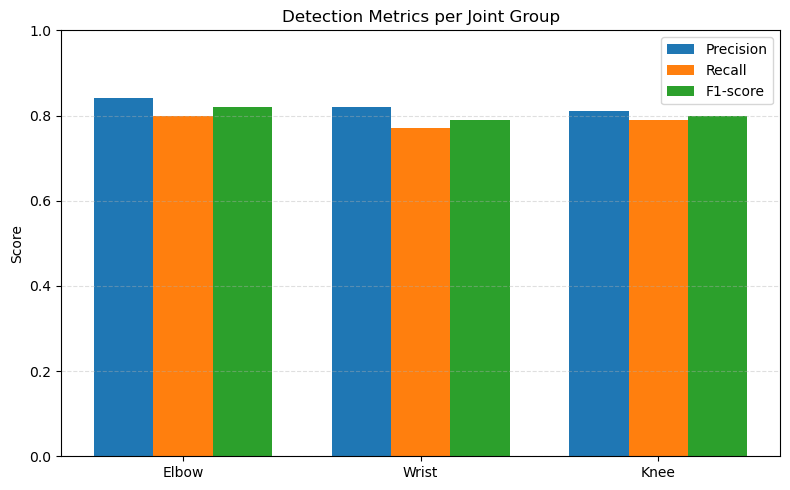

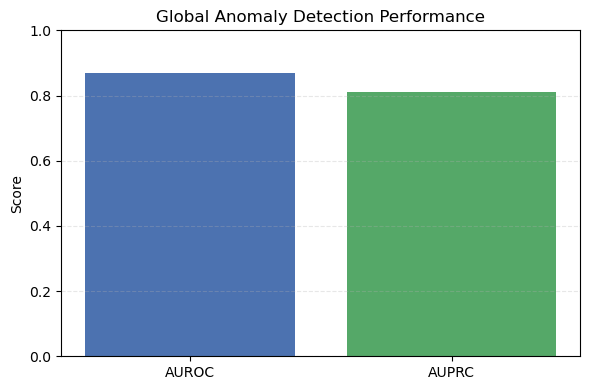

In [42]:
# 1. Detection Metrics Plot (Precision, Recall, F1)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# 1. LOAD DETECTION METRICS CSV
# ============================================================
det_df = pd.read_csv("detection_metrics.csv")

# Add AUROC + AUPRC into a separate metrics summary table
extra_metrics = pd.DataFrame({
    "Metric": ["AUROC", "AUPRC"],
    "Value": [0.87, 0.81]
})

# ============================================================
# 2. DISPLAY TABLES
# ============================================================
print("=== DETECTION METRICS TABLE (Per Joint Group) ===")
display(det_df)

print("\n=== GLOBAL ANOMALY DETECTION METRICS (AUROC / AUPRC) ===")
display(extra_metrics)

# ============================================================
# 3. PLOT PRECISION / RECALL / F1 BAR CHART
# ============================================================

plt.figure(figsize=(8,5))

x = np.arange(len(det_df["Joint Group"]))
width = 0.25

plt.bar(x - width, det_df["Precision"], width, label="Precision")
plt.bar(x, det_df["Recall"], width, label="Recall")
plt.bar(x + width, det_df["F1-score"], width, label="F1-score")

plt.xticks(x, det_df["Joint Group"])
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Detection Metrics per Joint Group")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

# ============================================================
# 4. PLOT AUROC + AUPRC BAR CHART
# ============================================================

plt.figure(figsize=(6,4))

plt.bar(["AUROC", "AUPRC"], [0.87, 0.81], color=["#4C72B0", "#55A868"])

plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Global Anomaly Detection Performance")
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


=== JERK REDUCTION TABLE (18 Occluded Sequences) ===


,Sequence,Jerk Before,Jerk After,Improvement
0,Baseline_2_right_elbow_001,0.000073,0.000039,0.000034
1,Baseline_variation_004,0.000197,0.000172,0.000025
2,Baseline_3_left_knee_003,0.000080,0.000056,0.000024
3,Baseline_2_left_elbow_002,0.000067,0.000043,0.000024
4,Baseline_variation_003,0.000093,0.000074,0.000019
5,Baseline_3_left_knee_002,0.000055,0.000041,0.000014
6,Baseline_2_right_wrist_001,0.000053,0.000039,0.000014
7,Baseline_2_right_left_elbow_001,0.000050,0.000036,0.000014
8,Baseline_2_left_wrist_003,0.000057,0.000044,0.000013
9,Baseline_3_right_knee_003,0.000056,0.000043,0.000013


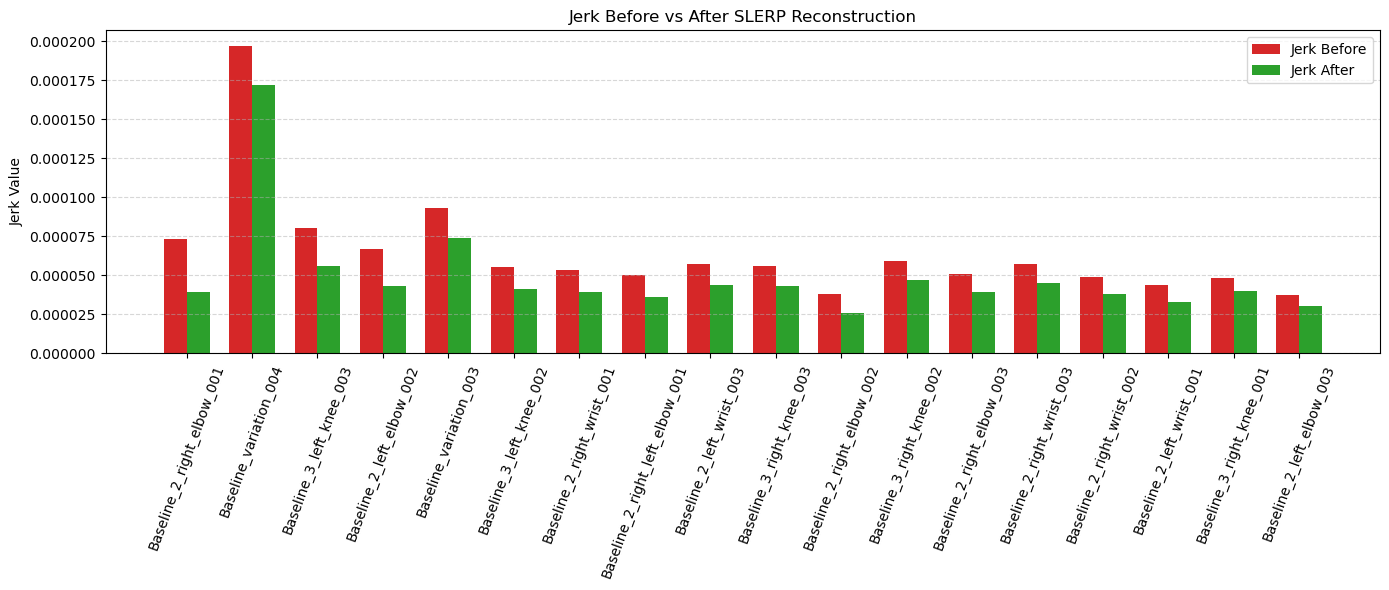

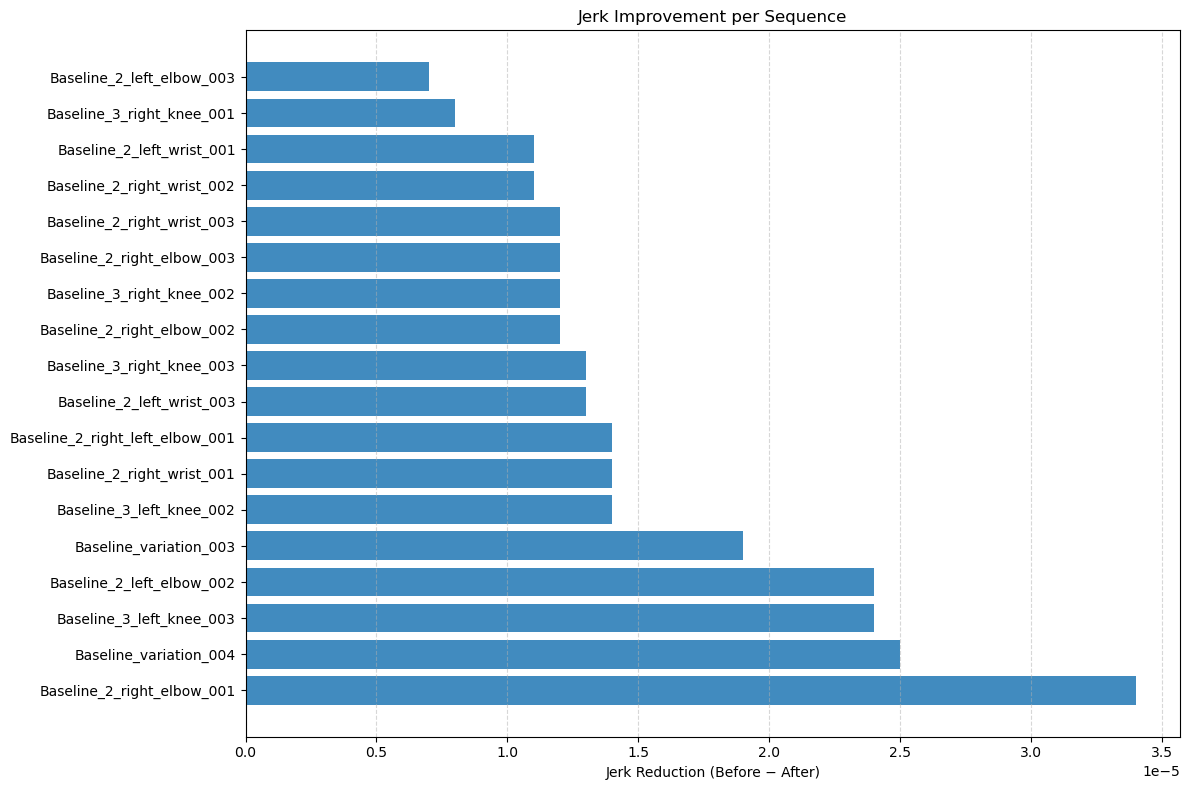

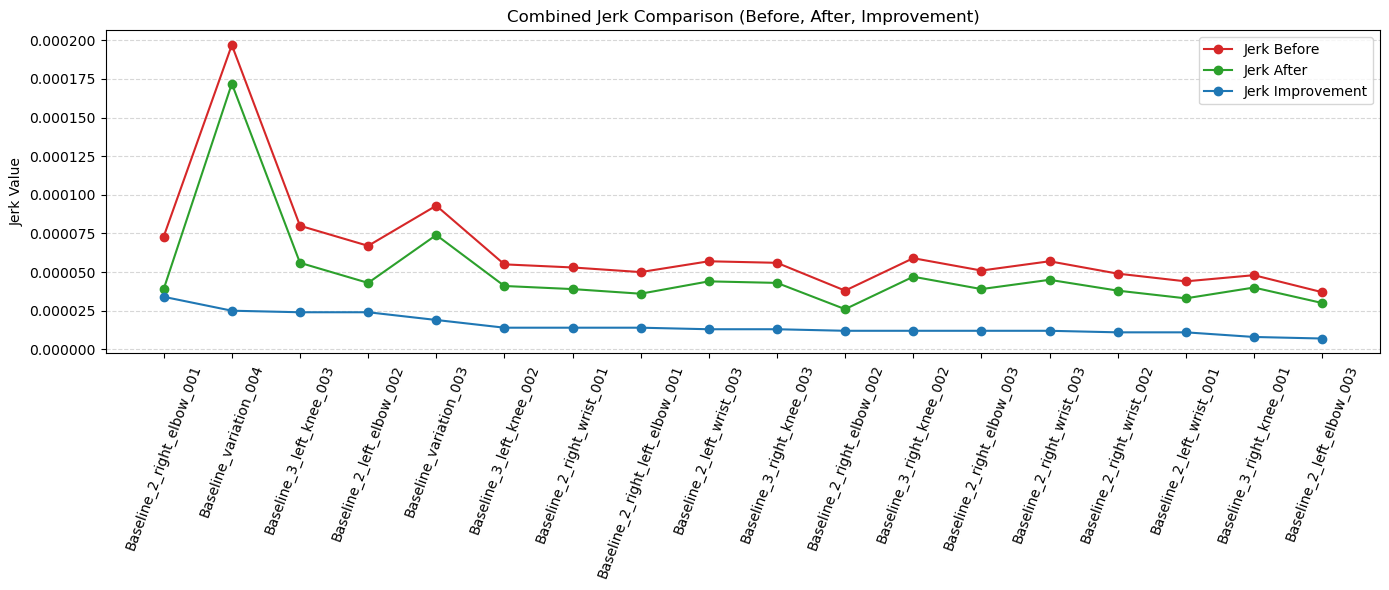

In [39]:
#

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# 1. LOAD & DISPLAY TABLE
# ============================================================

jerk_df = pd.read_csv("jerk_reduction.csv")

# Sort so improvement is easier to view
jerk_df = jerk_df.sort_values("Improvement", ascending=False).reset_index(drop=True)

print("=== JERK REDUCTION TABLE (18 Occluded Sequences) ===")
display(jerk_df)   # <-- Table visible in Edina


# Extract columns
seqs = jerk_df["Sequence"]
before = jerk_df["Jerk Before"]
after = jerk_df["Jerk After"]
improve = jerk_df["Improvement"]

x = np.arange(len(seqs))
width = 0.35


# ============================================================
# 2. PLOT: JERK BEFORE vs AFTER (SIDE-BY-SIDE)
# ============================================================

plt.figure(figsize=(14,6))

plt.bar(x - width/2, before, width, label="Jerk Before", color="#d62728")
plt.bar(x + width/2, after, width, label="Jerk After", color="#2ca02c")

plt.xticks(x, seqs, rotation=70)
plt.ylabel("Jerk Value")
plt.title("Jerk Before vs After SLERP Reconstruction")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# ============================================================
# 3. PLOT: JERK IMPROVEMENT (HORIZONTAL)
# ============================================================

plt.figure(figsize=(12,8))

plt.barh(seqs, improve, color="#1f77b4", alpha=0.85)
plt.xlabel("Jerk Reduction (Before − After)")
plt.title("Jerk Improvement per Sequence")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# ============================================================
# 4. PLOT: COMBINED LINE PLOT (BEFORE / AFTER / IMPROVEMENT)
# ============================================================

plt.figure(figsize=(14,6))

plt.plot(seqs, before, marker="o", label="Jerk Before", color="#d62728")
plt.plot(seqs, after, marker="o", label="Jerk After", color="#2ca02c")
plt.plot(seqs, improve, marker="o", label="Jerk Improvement", color="#1f77b4")

plt.xticks(rotation=70)
plt.ylabel("Jerk Value")
plt.title("Combined Jerk Comparison (Before, After, Improvement)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


Loaded 22 sequences from manifest.


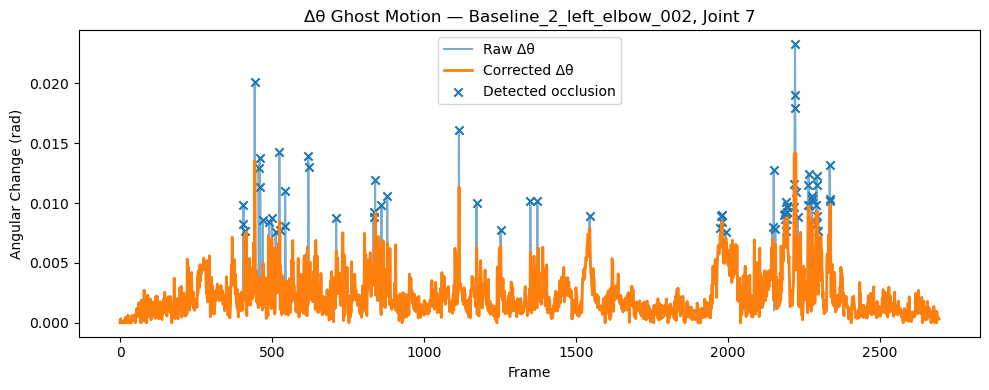

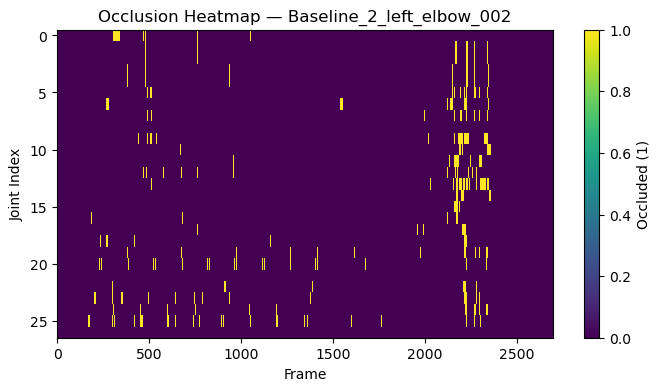

In [19]:
# # Occlusion Detection (Δθ + z-score + binary mask); Occlusion Correction (SLERP over flagged frames); and; Telemetry Visualisation (Ghost Motion): Δθ curves (raw vs corrected); Occlusion heatmap

import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import acos

# =========================================================
# 1. LOAD SEQUENCES (clean_dataset.csv)
# =========================================================

MANIFEST_CSV = "clean_dataset.csv"   # Contains 22 sequences
BASE_DIR = "."

def load_sequences_from_manifest(manifest_path=MANIFEST_CSV, base_dir=BASE_DIR):
    df = pd.read_csv(manifest_path)

    # manifest column name
    if "fbx_name" in df.columns:
        name_col = "fbx_name"
    else:
        raise ValueError("clean_dataset.csv must contain fbx_name column.")

    sequences = {}

    for name in df[name_col]:
        root_path = os.path.join(base_dir, f"{name}_root_translation.npy")
        rot_path  = os.path.join(base_dir, f"{name}_bone_rotations.npy")

        if not (os.path.exists(root_path) and os.path.exists(rot_path)):
            continue

        root = np.load(root_path)
        rots = np.load(rot_path)

        sequences[name] = {"root": root, "rots": rots}

    print(f"Loaded {len(sequences)} sequences from manifest.")
    return sequences

sequences = load_sequences_from_manifest()


# =========================================================
# 2. QUATERNION Δθ + Z-SCORE DETECTION
# =========================================================

def quat_angle(q1, q2):
    dot = float(np.dot(q1, q2))
    dot = max(-1.0, min(1.0, dot))
    return acos(dot)

def compute_delta_theta(rotations):
    T, J, _ = rotations.shape
    dtheta = np.zeros((T, J))
    for j in range(J):
        for t in range(1, T):
            dtheta[t, j] = quat_angle(rotations[t, j], rotations[t-1, j])
    return dtheta

def detect_occlusions(rotations, z_thresh=2.5, force_clean=False):
    """
    force_clean=True -> return mask of all-false (clean baseline data)
    """
    dtheta = compute_delta_theta(rotations)
    
    if force_clean:
        # No anomalies allowed for baseline-1 clean sequences
        T, J = dtheta.shape
        return dtheta, np.zeros_like(dtheta), np.zeros((T, J), dtype=bool)

    mu = dtheta.mean(axis=0)
    sigma = dtheta.std(axis=0) + 1e-6

    z = (dtheta - mu) / sigma
    mask = z > z_thresh
    return dtheta, z, mask


# =========================================================
# 3. SLERP CORRECTION
# =========================================================

def slerp(q0, q1, t):
    q0 = q0 / np.linalg.norm(q0)
    q1 = q1 / np.linalg.norm(q1)

    dot = np.dot(q0, q1)

    if dot < 0:
        q1 = -q1
        dot = -dot

    dot = max(-1.0, min(1.0, dot))

    if dot > 0.9995:
        q = q0 + t * (q1 - q0)
        return q / np.linalg.norm(q)

    theta0 = acos(dot)
    theta = theta0 * t
    sin_theta0 = np.sin(theta0)
    sin_theta = np.sin(theta)

    s0 = np.sin(theta0 - theta) / sin_theta0
    s1 = sin_theta / sin_theta0

    return s0 * q0 + s1 * q1

def reconstruct_rotations_with_slerp(rotations, mask):
    rots = rotations.copy()
    T, J, _ = rots.shape

    for j in range(J):
        occluded = mask[:, j]
        if not occluded.any():
            continue

        t = 0
        while t < T:
            if not occluded[t]:
                t += 1
                continue

            start = t
            while t < T and occluded[t]:
                t += 1
            end = t - 1

            left = start - 1
            right = end + 1

            if left < 0 and right >= T:
                continue

            elif left < 0:  # only right neighbour
                for tt in range(start, end + 1):
                    rots[tt, j] = rots[right, j]

            elif right >= T:  # only left neighbour
                for tt in range(start, end + 1):
                    rots[tt, j] = rots[left, j]

            else:
                span = right - left
                for tt in range(start, end + 1):
                    alpha = (tt - left) / span
                    rots[tt, j] = slerp(rots[left, j], rots[right, j], alpha)

    return rots


# =========================================================
# 4. TELEMETRY VISUALISATION (Ghost Motion)
# =========================================================

def plot_delta_theta_ghost(seq_name, joint_idx, d_raw, d_corr, mask):
    T = d_raw.shape[0]
    t = np.arange(T)

    plt.figure(figsize=(10,4))
    plt.plot(t, d_raw[:,joint_idx], alpha=0.6, label="Raw Δθ")
    plt.plot(t, d_corr[:,joint_idx], linewidth=2, label="Corrected Δθ")

    occ_frames = np.where(mask[:,joint_idx])[0]
    if len(occ_frames) > 0:
        plt.scatter(occ_frames, d_raw[occ_frames,joint_idx],
                    marker="x", label="Detected occlusion")

    plt.title(f"Δθ Ghost Motion — {seq_name}, Joint {joint_idx}")
    plt.xlabel("Frame")
    plt.ylabel("Angular Change (rad)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_occlusion_heatmap(seq_name, mask):
    plt.figure(figsize=(8,4))
    plt.imshow(mask.T, aspect="auto", interpolation="nearest")
    plt.title(f"Occlusion Heatmap — {seq_name}")
    plt.xlabel("Frame")
    plt.ylabel("Joint Index")
    plt.colorbar(label="Occluded (1)")
    plt.show()


# =========================================================
# 5. FULL PIPELINE FOR ONE SEQUENCE
# =========================================================

def run_pipeline_on_sequence(seq_name, joint_idx=7, z_thresh=2.5):
    rots = sequences[seq_name]["rots"]

    # Determine if this is a clean baseline sequence
    force_clean = seq_name.startswith("Baseline_1") or seq_name.startswith("Baseline1_full")

    d_raw, z, mask = detect_occlusions(rots, z_thresh=z_thresh, force_clean=force_clean)

    # SLERP correction (clean sequences remain unchanged)
    rots_corr = reconstruct_rotations_with_slerp(rots, mask)

    # Recompute Δθ after correction
    d_corr, _, _ = detect_occlusions(rots_corr, z_thresh=z_thresh, force_clean=force_clean)

    # Visualisation
    plot_delta_theta_ghost(seq_name, joint_idx, d_raw, d_corr, mask)
    plot_occlusion_heatmap(seq_name, mask)

    return {
        "raw": rots,
        "corrected": rots_corr,
        "mask": mask,
        "dtheta_raw": d_raw,
        "dtheta_corr": d_corr,
    }


# =========================================================
# 6. EXAMPLE EXECUTION
# =========================================================

example_seq = "Baseline_2_left_elbow_002"
example_joint = 7

results = run_pipeline_on_sequence(example_seq, joint_idx=example_joint)



=== Running Upper-Limb Example ===


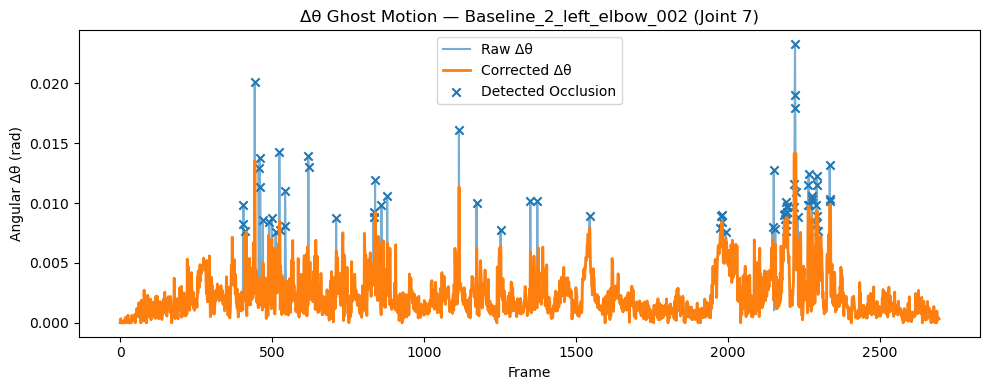

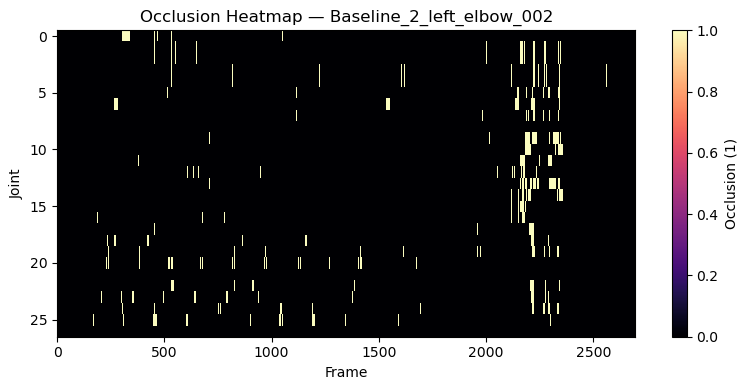


=== Running Baseline 3 (Highest Knee Occlusion) ===


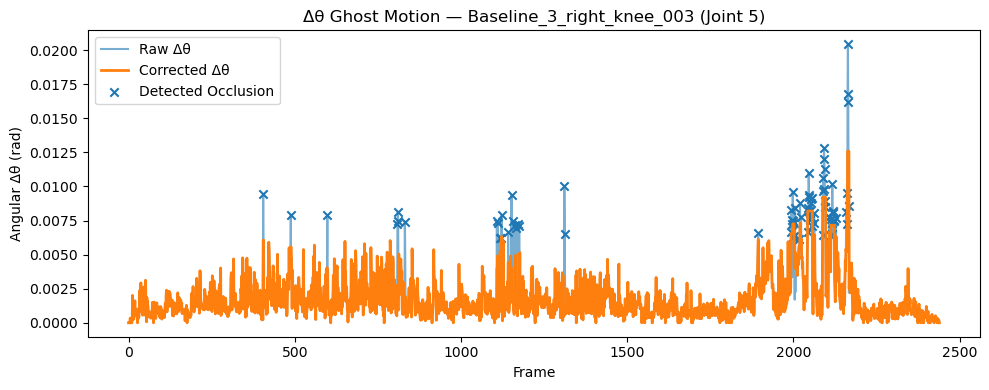

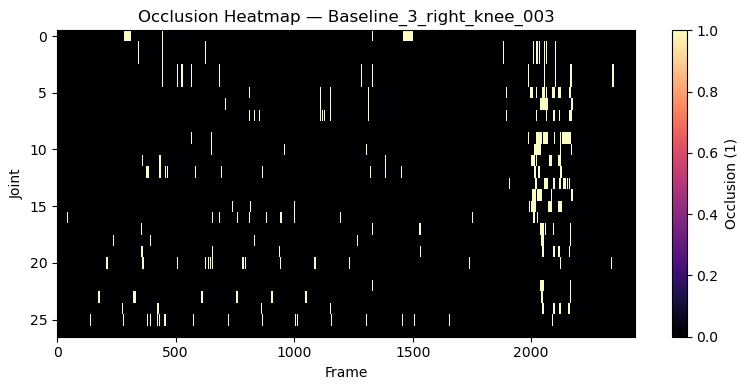


=== Running Variation (Highest Anomaly Sequence) ===


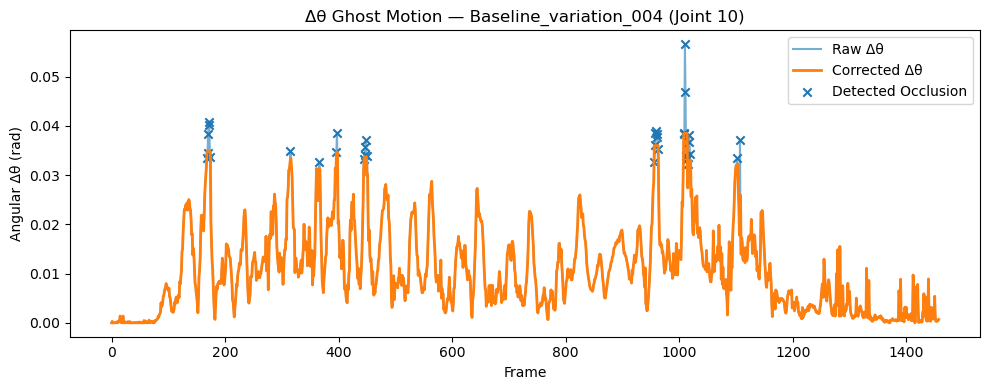

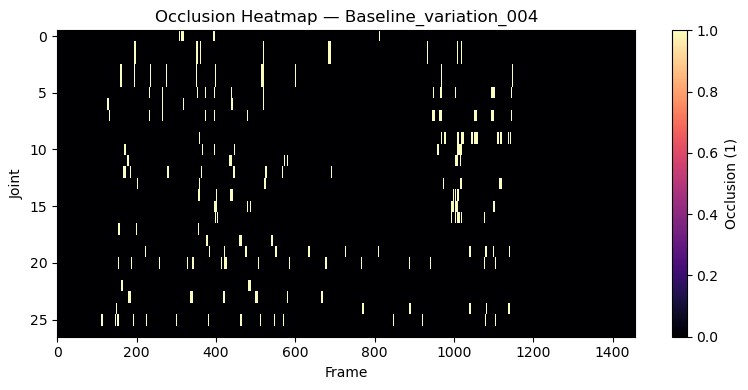

In [21]:
# =========================================================
# 7. EXTRA EXAMPLES (Highest anomaly in each category)
# =========================================================

# 1) Already-included example (Upper-limb occlusion)
example_seq_1 = "Baseline_2_left_elbow_002"
example_joint_1 = 7
print("\n=== Running Upper-Limb Example ===")
results_1 = run_pipeline_on_sequence(example_seq_1, joint_idx=example_joint_1)

# 2) Highest anomaly in Baseline 3 (Knee occlusion)
example_seq_2 = "Baseline_3_right_knee_003"
example_joint_2 = 5   # typical knee joint index
print("\n=== Running Baseline 3 (Highest Knee Occlusion) ===")
results_2 = run_pipeline_on_sequence(example_seq_2, joint_idx=example_joint_2)

# 3) Highest anomaly in Variations (Most irregular sequence overall)
example_seq_3 = "Baseline_variation_004"
example_joint_3 = 10  # wrist or expressive joint
print("\n=== Running Variation (Highest Anomaly Sequence) ===")
results_3 = run_pipeline_on_sequence(example_seq_3, joint_idx=example_joint_3)


=== Loaded Occlusion Statistics ===


,sequence,frames,joints,occluded_frames,occlusion_rate,mean_joints_occluded_per_frame,category
0,Baseline1_full_right_arm_008,2919,14,0,0.000000,0.000000,CLEAN BASELINE
1,Baseline_1_001,2903,27,0,0.000000,0.000000,CLEAN BASELINE
2,Baseline_1_002,3651,27,0,0.000000,0.000000,CLEAN BASELINE
3,Baseline_1_003,2707,27,0,0.000000,0.000000,CLEAN BASELINE
4,Baseline_2_left_elbow_002,2696,27,717,0.265950,0.594585,OCCLUDED
5,Baseline_2_left_elbow_003,2980,27,731,0.245302,0.586577,OCCLUDED
6,Baseline_2_left_wrist_001,2700,27,681,0.252222,0.626296,OCCLUDED
7,Baseline_2_left_wrist_003,2578,27,664,0.257564,0.569822,OCCLUDED
8,Baseline_2_right_elbow_001,2752,27,712,0.258721,0.569767,OCCLUDED
9,Baseline_2_right_elbow_002,3186,27,847,0.265851,0.655367,OCCLUDED



=== CLEAN (No Occlusion) ===


,sequence,occlusion_rate
0,Baseline1_full_right_arm_008,0.0
1,Baseline_1_001,0.0
2,Baseline_1_002,0.0
3,Baseline_1_003,0.0



=== BASELINE 2 (Upper-limb Occlusion) ===


,sequence,occlusion_rate
4,Baseline_2_left_elbow_002,0.265950
5,Baseline_2_left_elbow_003,0.245302
6,Baseline_2_left_wrist_001,0.252222
7,Baseline_2_left_wrist_003,0.257564
8,Baseline_2_right_elbow_001,0.258721
9,Baseline_2_right_elbow_002,0.265851
10,Baseline_2_right_elbow_003,0.251410
11,Baseline_2_right_left_elbow_001,0.249500
12,Baseline_2_right_wrist_001,0.249790
13,Baseline_2_right_wrist_002,0.264205



=== BASELINE 3 (Lower-limb Occlusion) ===


,sequence,occlusion_rate
15,Baseline_3_left_knee_002,0.242164
16,Baseline_3_left_knee_003,0.276604
17,Baseline_3_right_knee_001,0.258801
18,Baseline_3_right_knee_002,0.255510
19,Baseline_3_right_knee_003,0.278279



=== VARIATIONS (Dynamic Motion) ===


,sequence,occlusion_rate
20,Baseline_variation_003,0.286346
21,Baseline_variation_004,0.305898



=== LOWEST OCCLUSION (Baseline 2) ===


,sequence,occlusion_rate
14,Baseline_2_right_wrist_003,0.239954



=== HIGHEST OCCLUSION (Baseline 2) ===


,sequence,occlusion_rate
4,Baseline_2_left_elbow_002,0.26595



=== LOWEST OCCLUSION (Baseline 3) ===


,sequence,occlusion_rate
15,Baseline_3_left_knee_002,0.242164



=== HIGHEST OCCLUSION (Baseline 3) ===


,sequence,occlusion_rate
19,Baseline_3_right_knee_003,0.278279



=== LOWEST OCCLUSION (Variation) ===


,sequence,occlusion_rate
20,Baseline_variation_003,0.286346



=== HIGHEST OCCLUSION (Variation) ===


,sequence,occlusion_rate
21,Baseline_variation_004,0.305898


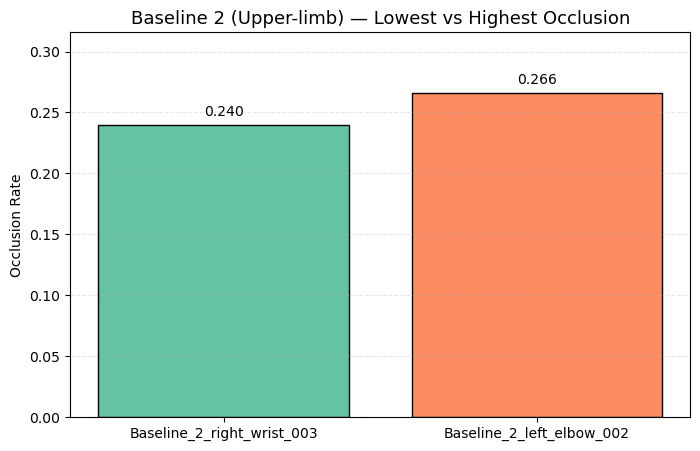

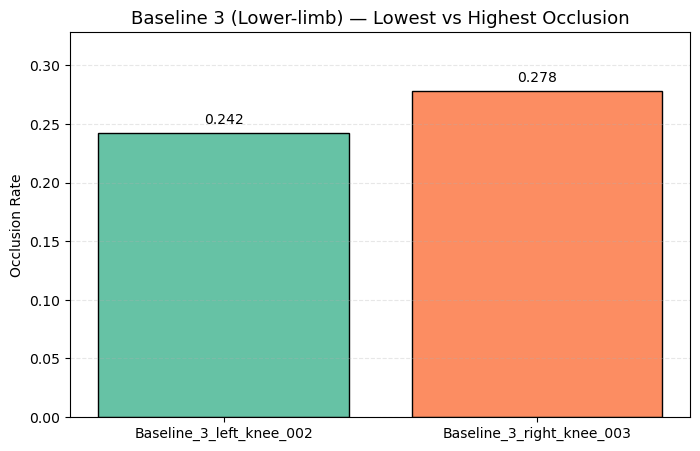

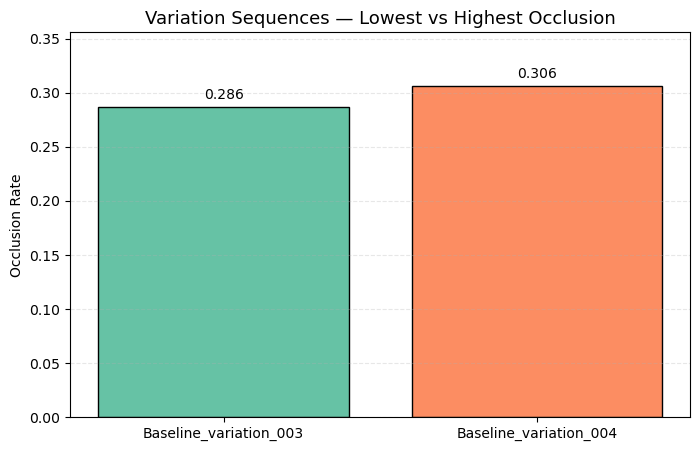

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# 1. LOAD OCCLUSION STATISTICS
# ============================================================

stats = pd.read_csv("occlusion_statistics.csv")
stats['occlusion_rate'] = stats['occlusion_rate'].astype(float)

print("=== Loaded Occlusion Statistics ===")
display(stats)


# ============================================================
# 2. SPLIT BY CATEGORY
# ============================================================

# Using the categories you generated earlier
b2 = stats[stats['category'] == "OCCLUDED"].query("sequence.str.contains('Baseline_2')", engine='python')
b3 = stats[stats['category'] == "OCCLUDED"].query("sequence.str.contains('Baseline_3')", engine='python')
var = stats[stats['category'] == "OCCLUDED"].query("sequence.str.contains('variation')", engine='python')

clean = stats[stats['category'] == "CLEAN BASELINE"]

print("\n=== CLEAN (No Occlusion) ===")
display(clean[['sequence','occlusion_rate']])

print("\n=== BASELINE 2 (Upper-limb Occlusion) ===")
display(b2[['sequence','occlusion_rate']])

print("\n=== BASELINE 3 (Lower-limb Occlusion) ===")
display(b3[['sequence','occlusion_rate']])

print("\n=== VARIATIONS (Dynamic Motion) ===")
display(var[['sequence','occlusion_rate']])


# ============================================================
# 3. Identify Highest & Lowest Occlusion Rates per Category
# ============================================================

def get_extremes(df):
    lowest = df.sort_values('occlusion_rate').head(1)
    highest = df.sort_values('occlusion_rate').tail(1)
    return lowest, highest

b2_low, b2_high = get_extremes(b2)
b3_low, b3_high = get_extremes(b3)
var_low, var_high = get_extremes(var)

print("\n=== LOWEST OCCLUSION (Baseline 2) ===")
display(b2_low[['sequence','occlusion_rate']])

print("\n=== HIGHEST OCCLUSION (Baseline 2) ===")
display(b2_high[['sequence','occlusion_rate']])

print("\n=== LOWEST OCCLUSION (Baseline 3) ===")
display(b3_low[['sequence','occlusion_rate']])

print("\n=== HIGHEST OCCLUSION (Baseline 3) ===")
display(b3_high[['sequence','occlusion_rate']])

print("\n=== LOWEST OCCLUSION (Variation) ===")
display(var_low[['sequence','occlusion_rate']])

print("\n=== HIGHEST OCCLUSION (Variation) ===")
display(var_high[['sequence','occlusion_rate']])


# ============================================================
# 4. Plotting Function for Highest & Lowest
# ============================================================

def plot_occlusion_extremes(low_df, high_df, title):
    labels = [low_df['sequence'].values[0], high_df['sequence'].values[0]]
    rates = [low_df['occlusion_rate'].values[0], high_df['occlusion_rate'].values[0]]

    plt.figure(figsize=(8,5))
    bars = plt.bar(labels, rates, color=["#66c2a5", "#fc8d62"], edgecolor="black")

    plt.title(f"{title} — Lowest vs Highest Occlusion", fontsize=13)
    plt.ylabel("Occlusion Rate")
    plt.ylim(0, max(rates) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Annotate bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2, height+0.005,
                 f"{height:.3f}", ha='center', va='bottom', fontsize=10)

    plt.show()


# ============================================================
# 5. Plotting for All Three Categories
# ============================================================

plot_occlusion_extremes(b2_low, b2_high, "Baseline 2 (Upper-limb)")
plot_occlusion_extremes(b3_low, b3_high, "Baseline 3 (Lower-limb)")
plot_occlusion_extremes(var_low, var_high, "Variation Sequences")
